In [122]:
import warnings
warnings.filterwarnings('ignore')

In [123]:
import os
import numpy as np
import pandas as pd
import spacy
from spacy import displacy
import itertools as it
import re
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_lg")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nevin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#execute only once
#!python -m spacy download en_core_web_lg 

In [243]:
data = pd.read_csv('Merged_data_with_date_topic_modelling_1.csv')
reviews_df = data[['review_body']]
reviews_df.head()

,review_body
0,My flight from Dulles to Paris was great. My f...
1,"I went for 2 months to Nice, when I arrived i..."
2,"Yesterday Jan 25, we flew Colombo, Sri Lanka t..."
3,First medium-haul experience with Air France....
4,BOD-CDG-ATL: Was having some major issue with...


In [244]:
data.head()

,Unnamed: 0,score,title,user_country,user_name,review_date,is_verified,review_body,airline,seat,...,Type Of Traveller,Value For Money,Inflight Entertainment,Wifi & Connectivity,link,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,"""my trip was pretty good.""",United States,N Palustre,02/09/2022,0,My flight from Dulles to Paris was great. My f...,Air France,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0.3903,"aircraft, cabin, service, food, crew, front, e...",my flight from dulles to paris was great my fl...
1,1,1.0,"""my baggage didn't make it""",Lebanon,Nour El Khoury,27/01/2022,1,"I went for 2 months to Nice, when I arrived i...",Air France,NaN,...,NaN,NaN,NaN,NaN,NaN,1,5,0.2697,"people, way, person, bag, problem, issue, staf...",i went for months to nice when i arrived in ni...
2,2,3.0,Air France customer review,United States,Daniel Rabourn,26/01/2022,1,"Yesterday Jan 25, we flew Colombo, Sri Lanka t...",Air France,NaN,...,NaN,NaN,NaN,NaN,NaN,2,2,0.3012,"economy, aisle, screen, bulkhead, premium, rec...",yesterday jan we flew colombo sri lanka to par...
3,3,8.0,"""great alternative to fly across the Atlantic""",United Kingdom,D Garlin,19/01/2022,1,First medium-haul experience with Air France....,Air France,NaN,...,NaN,NaN,NaN,NaN,NaN,3,0,0.4593,"aircraft, cabin, service, food, crew, front, e...",first medium haul experience with air france t...
4,4,8.0,"""A pleasurable experience!""",United States,S Gillemo,01/04/2022,1,BOD-CDG-ATL: Was having some major issue with...,Air France,NaN,...,NaN,NaN,NaN,NaN,NaN,4,3,0.3121,"airline, trip, year, money, book, return, day,...",bod cdg atl was having some major issue with d...


In [245]:
#case text to lower case, remove punctuation, remove extra whitepsace in the string and on both sides of the string
reviews_df['review_body'] = reviews_df['review_body'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()

reviews_df.head(5)

,review_body
0,my flight from dulles to paris was great my fl...
1,i went for months to nice when i arrived in ni...
2,yesterday jan we flew colombo sri lanka to par...
3,first medium haul experience with air france t...
4,bod cdg atl was having some major issue with d...


In [247]:
reviews_list = reviews_df.review_body.values.tolist()

In [248]:
reviews_list[12]

'i purchased my ticket over weeks ago they cancelled my flight which is understandable but when i tried to contact their customer service line i waited for over mins on the line without an answer times within days finally on the final attempt my call was answered at mins waiting time i was relieved finally i could speak to a human being and ask for help to my situation the customer service rep literally said sorry there is nothing we can do good bye and preceded to hang up on me'

In [ ]:
# Remove Emails
#reviews_list = [re.sub(r'\S*|\S*\s?', '', sent) for sent in reviews_list]
#reviews_list = [re.sub(r'\s+', ' ', sent) for sent in reviews_list]
#reviews_list = [re.sub(r"\'", "", sent) for sent in reviews_list]

In [249]:
len(reviews_list)

34392

In [213]:
reviews_list[0]

'yesterday jan we flew colombo sri lanka to paris a hour flight we were fed an ok meal about hour into the flight for the next over hours we were not offered even a water nothing and my coffee cup and my wifes wine glass from dinner remained in the cupholders untouched for over hours the flight attendants were non existent many people around us complaining no excuse for this on a smooth flight with no turbulence'

In [250]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(reviews_list))

In [215]:
pprint(data_words[:2])

[['yesterday',
  'jan',
  'we',
  'flew',
  'colombo',
  'sri',
  'lanka',
  'to',
  'paris',
  'hour',
  'flight',
  'we',
  'were',
  'fed',
  'an',
  'ok',
  'meal',
  'about',
  'hour',
  'into',
  'the',
  'flight',
  'for',
  'the',
  'next',
  'over',
  'hours',
  'we',
  'were',
  'not',
  'offered',
  'even',
  'water',
  'nothing',
  'and',
  'my',
  'coffee',
  'cup',
  'and',
  'my',
  'wifes',
  'wine',
  'glass',
  'from',
  'dinner',
  'remained',
  'in',
  'the',
  'cupholders',
  'untouched',
  'for',
  'over',
  'hours',
  'the',
  'flight',
  'attendants',
  'were',
  'non',
  'existent',
  'many',
  'people',
  'around',
  'us',
  'complaining',
  'no',
  'excuse',
  'for',
  'this',
  'on',
  'smooth',
  'flight',
  'with',
  'no',
  'turbulence'],
 ['it',
  'was',
  'very',
  'nice',
  'having',
  'wide',
  'body',
  'with',
  'lie',
  'flat',
  'business',
  'class',
  'layout',
  'on',
  'moscow',
  'to',
  'paris',
  'segment',
  'seats',
  'were',
  'comfortab

In [255]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['i', ' ', 'w', 'e', 'n', 't', ' ', 'f', 'o', 'r', ' ', 'm', 'o', 'n', 't', 'h', 's', ' ', 't', 'o', ' ', 'n', 'i', 'c', 'e', ' ', 'w', 'h', 'e', 'n', ' ', 'i', ' ', 'a', 'r', 'r', 'i', 'v', 'e', 'd', ' ', 'i', 'n', ' ', 'n', 'i', 'c', 'e', ' ', 'm', 'y', ' ', 'b', 'a', 'g', 'g', 'a', 'g', 'e', ' ', 'c', 'a', 'm', 'e', ' ', 'w', 'i', 't', 'h', ' ', 'm', 'e', ' ', 'i', 'n', ' ', 'm', 'y', ' ', 'r', 'e', 't', 'u', 'r', 'n', ' ', 't', 'o', ' ', 'l', 'e', 'b', 'a', 'n', 'o', 'n', ' ', 'm', 'y', ' ', 'b', 'a', 'g', 'g', 'a', 'g', 'e', ' ', 'd', 'i', 'd', 'n', 't', ' ', 'm', 'a', 'k', 'e', ' ', 'i', 't', ' ', 'd', 'a', 'y', 's', ' ', 'n', 'o', 'w', ' ', 'i', ' ', 'c', 'a', 'l', 'l', ' ', 'd', 'a', 'i', 'l', 'y', ' ', 'a', 'n', 'd', ' ', 'c', 'h', 'e', 'c', 'k', ' ', 'o', 'n', 'l', 'i', 'n', 'e', ' ', 's', 't', 'a', 't', 'u', 's', ' ', 'o', 'f', ' ', 'm', 'y', ' ', 'c', 'l', 'a', 'i', 'm', ' ', 'd', 'a', 'i', 'l', 'y', ' ', 'n', 'o', ' ', 'n', 'e', 'w', 's']


In [252]:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):#, 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [254]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#print(data_words_bigrams[:1])
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])#, 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['flight', 'dulles', 'paris', 'great', 'flight', 'attendant', 'super', 'nice', 'friendly', 'unlike', 'cabin', 'crew', 'speaking', 'french', 'like', 'spoke', 'language', 'seat', 'pitch', 'okay', 'lots', 'movies', 'watch', 'food', 'good', 'point', 'view', 'cant', 'complain', 'trip', 'pretty', 'good', 'flight', 'morocco', 'good', 'service', 'good', 'food']]


In [219]:
print(data_lemmatized[:2])

[['yesterday', 'meal', 'hour', 'flight', 'hour', 'coffee', 'cup', 'wine', 'glass', 'dinner', 'cupholder', 'hour', 'flight', 'attendant', 'non_existent', 'people', 'excuse', 'flight', 'turbulence'], ['body', 'lie_flat', 'business', 'class', 'layout', 'seat', 'wifi', 'crew', 'amenity', 'side', 'blanket', 'pillow', 'catering', 'bit', 'side', 'salad', 'food', 'hour', 'flight', 'kind', 'tea', 'thing', 'lemon', 'airport', 'layout', 'staff', 'member', 'passenger', 'transfer', 'leg', 'hour', 'hop', 'business', 'class', 'seat', 'foie', 'gras', 'snack', 'touch', 'experience', 'airline', 'option', 'mile', 'fare', 'schedule', 'widebody', 'moscow', 'flight', 'respect', 'peer', 'transit', 'airline', 'hub', 'transit', 'seat', 'staff', 'customer', 'experience', 'segmentation', 'perspective', 'type', 'airline', 'addition', 'terminal', 'review', 'hour', 'passport_control', 'queue']]


In [220]:
data_lemmatized[12]

['plane',
 'service',
 'flight',
 'attendant',
 'seat',
 'people',
 'hour',
 'flight',
 'flight',
 'attendant',
 'glass',
 'water',
 'response',
 'cart',
 'plane',
 'people',
 'glass',
 'water']

In [221]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=20, no_above=0.4)
id2word.compactify()

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 3), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [222]:
id2word[17]

'body'

In [240]:
# Human readable format of corpus (term-frequency)
words = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
words

[[('attendant', 1),
  ('coffee', 1),
  ('cup', 1),
  ('dinner', 1),
  ('flight', 3),
  ('glass', 1),
  ('hour', 3),
  ('meal', 1),
  ('non_existent', 1),
  ('people', 1),
  ('wine', 1)],
 [('flight', 2),
  ('hour', 3),
  ('addition', 1),
  ('airline', 3),
  ('airport', 1),
  ('amenity', 1),
  ('bit', 1),
  ('blanket', 1),
  ('body', 1),
  ('business', 2),
  ('catering', 1),
  ('class', 2),
  ('crew', 1),
  ('customer', 1),
  ('experience', 2),
  ('fare', 1),
  ('food', 1),
  ('kind', 1),
  ('layout', 2),
  ('leg', 1),
  ('lie_flat', 1),
  ('member', 1),
  ('mile', 1),
  ('option', 1),
  ('passenger', 1),
  ('pillow', 1),
  ('queue', 1),
  ('respect', 1),
  ('review', 1),
  ('side', 2),
  ('snack', 1),
  ('staff', 2),
  ('tea', 1),
  ('terminal', 1),
  ('thing', 1),
  ('touch', 1),
  ('transfer', 1),
  ('transit', 2),
  ('type', 1),
  ('wifi', 1)],
 [('attendant', 1),
  ('flight', 1),
  ('business', 2),
  ('class', 2),
  ('snack', 1),
  ('bag', 1)],
 [('class', 2),
  ('mile', 1),
  ('ar

In [224]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=75,
                                           alpha='auto',
                                           per_word_topics=True)

In [225]:
pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

[(0,
  '0.146*"staff" + 0.062*"ton" + 0.048*"child" + 0.038*"love" + 0.034*"man" + '
  '0.031*"bassinet" + 0.029*"ground" + 0.026*"ride" + 0.022*"hope" + '
  '0.020*"discomfort"'),
 (1,
  '0.184*"class" + 0.130*"business" + 0.053*"service" + 0.043*"airline" + '
  '0.042*"food" + 0.028*"seating" + 0.025*"bed" + 0.021*"experience" + '
  '0.019*"year" + 0.019*"trip"'),
 (2,
  '0.297*"flight" + 0.068*"time" + 0.066*"hour" + 0.041*"sleep" + '
  '0.034*"configuration" + 0.033*"attendant" + 0.022*"emergency" + '
  '0.018*"meal" + 0.018*"privacy" + 0.016*"air"'),
 (3,
  '0.097*"economy" + 0.044*"foot" + 0.035*"storage" + 0.034*"passenger" + '
  '0.029*"bulkhead" + 0.027*"aircraft" + 0.024*"cabin" + 0.023*"premium" + '
  '0.023*"armrest" + 0.023*"recline"'),
 (4,
  '0.142*"row" + 0.102*"leg" + 0.098*"room" + 0.087*"window" + 0.070*"plane" + '
  '0.069*"space" + 0.036*"exit" + 0.035*"side" + 0.027*"front" + 0.020*"door"'),
 (5,
  '0.230*"aisle" + 0.167*"people" + 0.069*"lavatory" + 0.037*"airpla

In [228]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4192,"flight, time, hour, sleep, configuration, atte...","[yesterday, meal, hour, flight, hour, coffee, ..."
1,1,1.0,0.3318,"class, business, service, airline, food, seati...","[body, lie_flat, business, class, layout, seat..."
2,2,1.0,0.2773,"class, business, service, airline, food, seati...","[flight, attendant, business, class, snack, ca..."
3,3,3.0,0.4437,"economy, foot, storage, passenger, bulkhead, a...","[economy, class, mile, partner, traveler, gold..."
4,4,2.0,0.3509,"flight, time, hour, sleep, configuration, atte...","[experience, trip, flight, flight, hour, fligh..."
5,5,4.0,0.3971,"row, leg, room, window, plane, space, exit, si...","[delay, leg, information, time, service, aircr..."
6,6,1.0,0.4692,"class, business, service, airline, food, seati...","[business, class, several_time, business, clas..."
7,7,4.0,0.2814,"row, leg, room, window, plane, space, exit, si...","[phone, book, business, class, economy, flight..."
8,8,1.0,0.2777,"class, business, service, airline, food, seati...","[business, class, flight, cph, flight, buenos_..."
9,9,4.0,0.3926,"row, leg, room, window, plane, space, exit, si...","[flight, year, gsqr, personnel, experience, se..."


In [229]:
df_dominant_topic["Dominant_Topic"].value_counts()

4.0    6827
3.0    4657
1.0    1041
2.0     351
5.0       2
Name: Dominant_Topic, dtype: int64

In [161]:
df_dominant_topic.to_csv('topic_modelling_lemmatized.csv')

In [91]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.47699042427528

Coherence Score:  0.5316870464874995


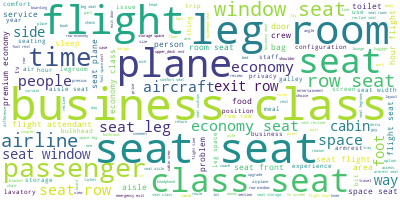

In [242]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = " ".join(map(" ".join, data_lemmatized))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

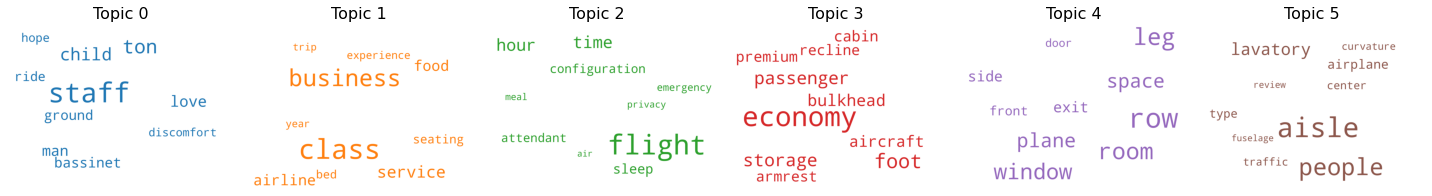

In [230]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 6, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

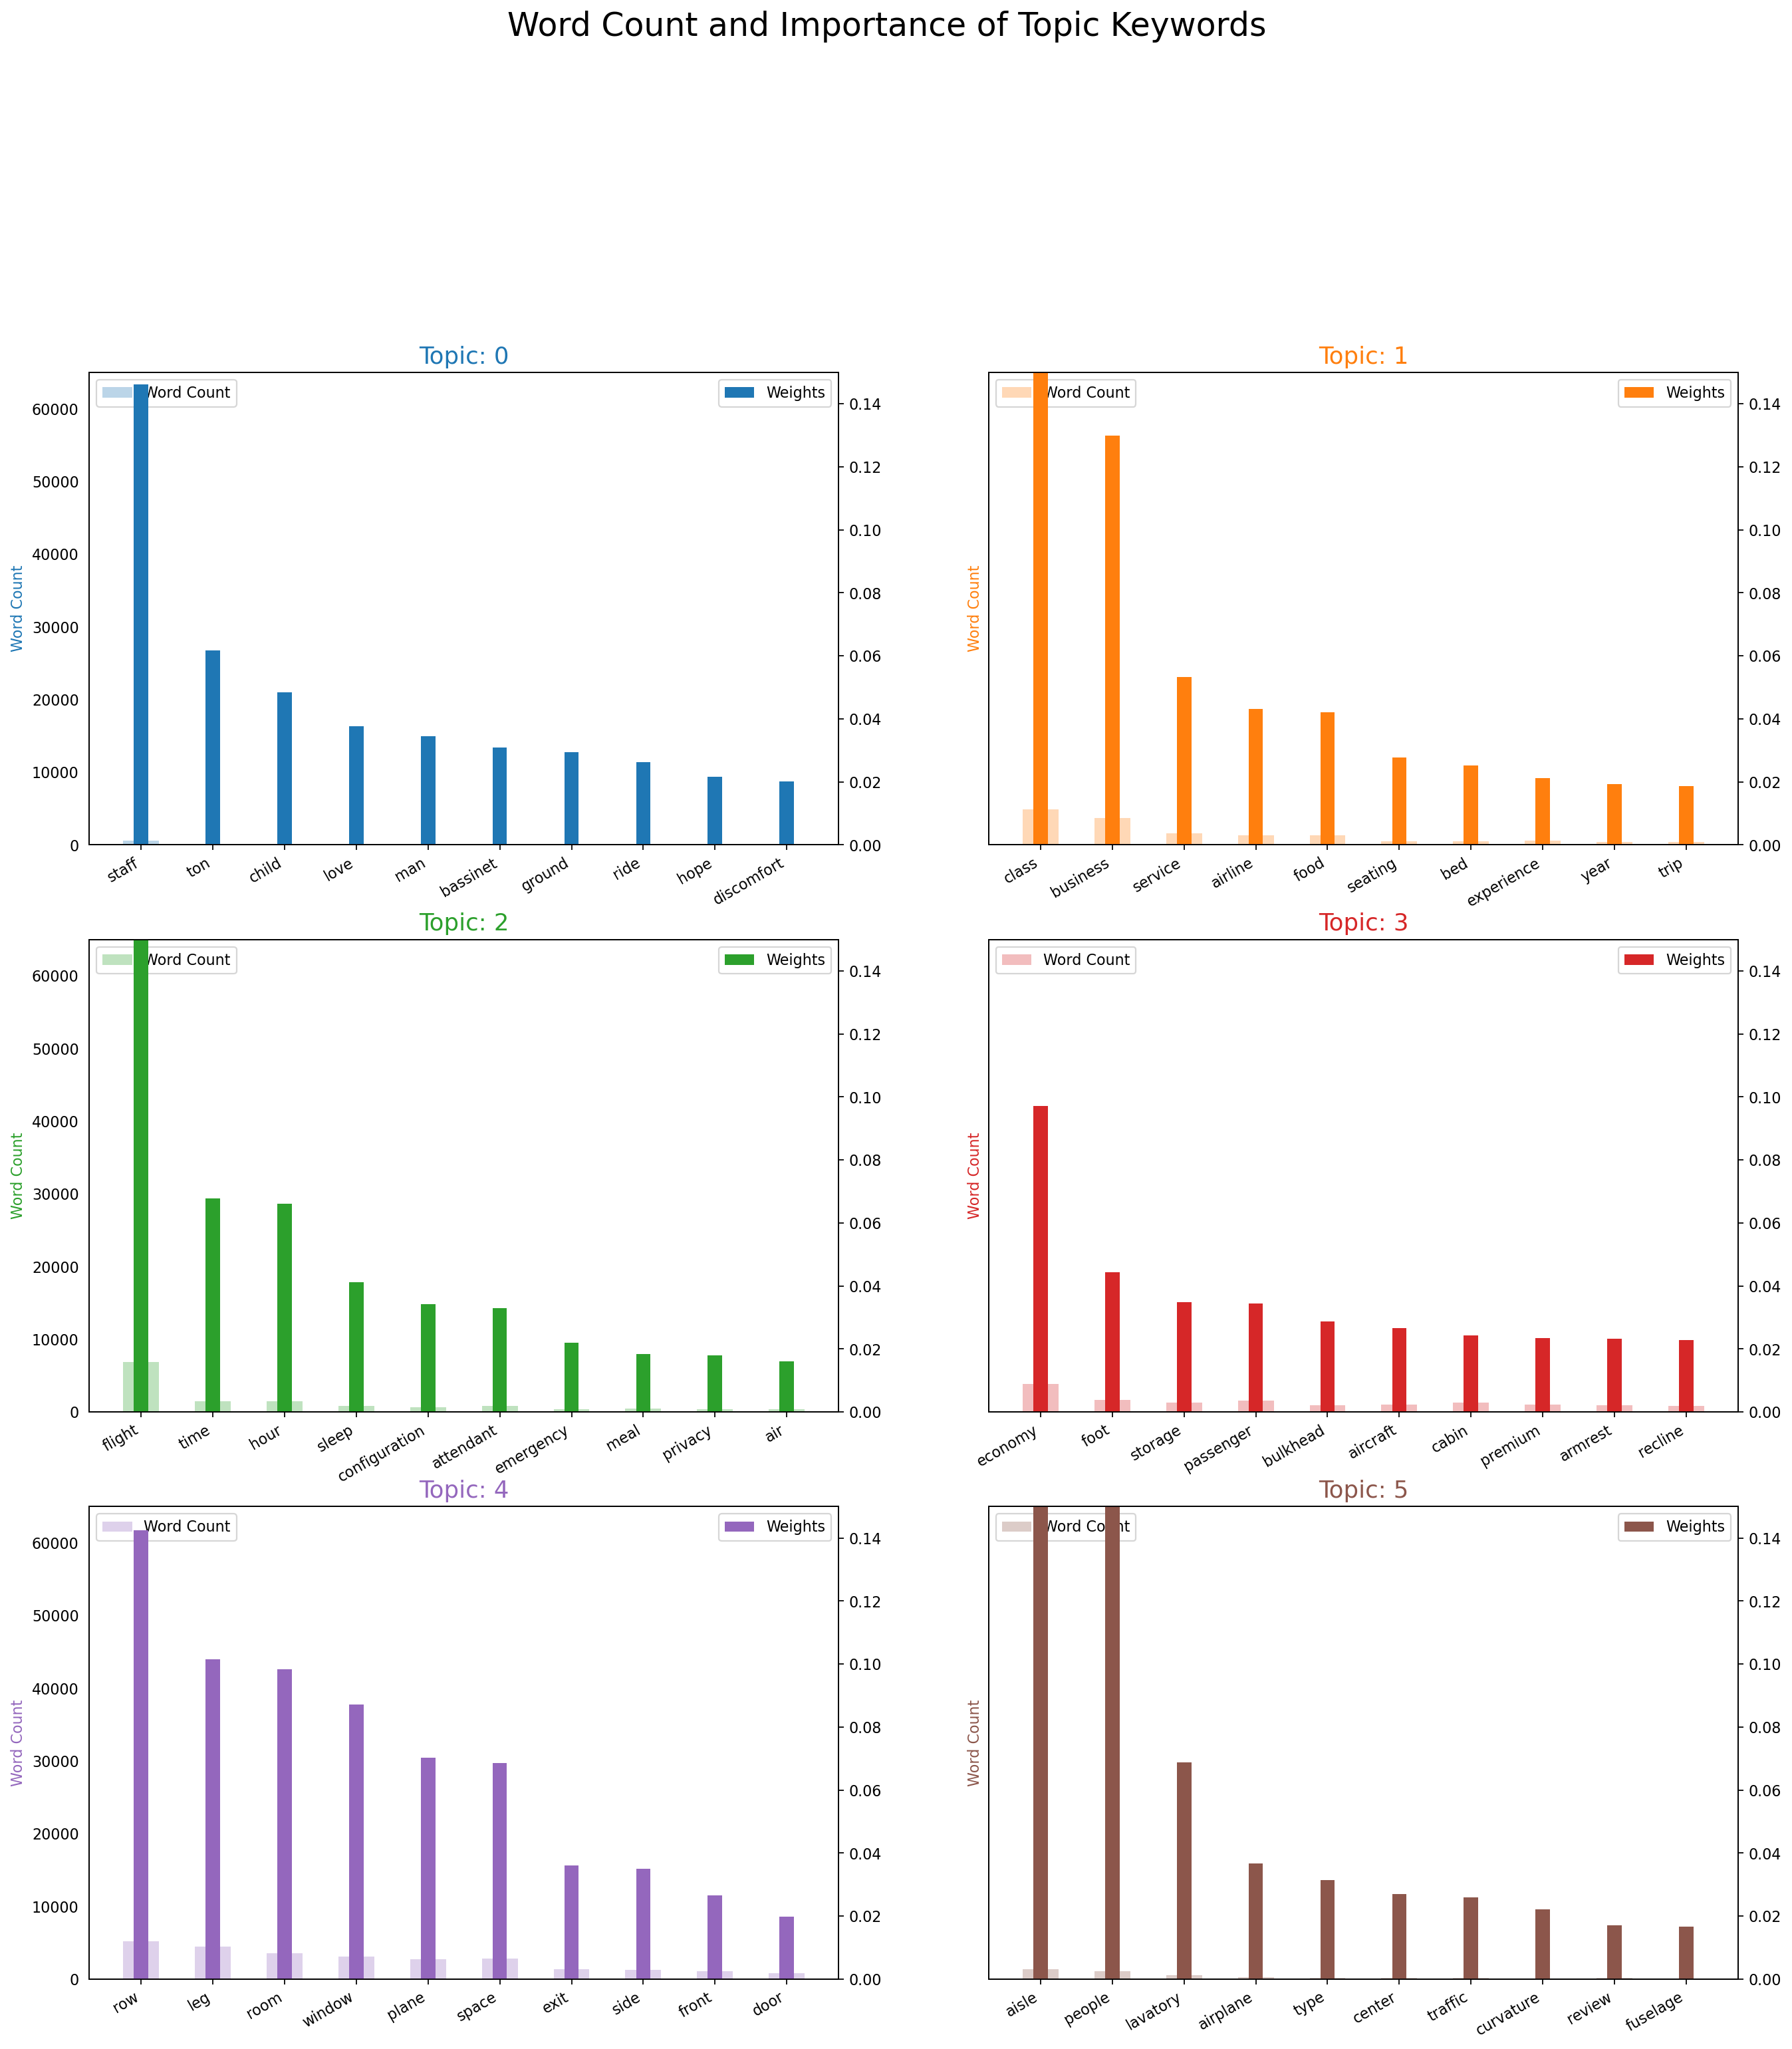

In [231]:
# Word counts of topic keywords
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.150); ax.set_ylim(0, 65000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

#fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [232]:
## To know most discussed topics in the documents

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 10]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

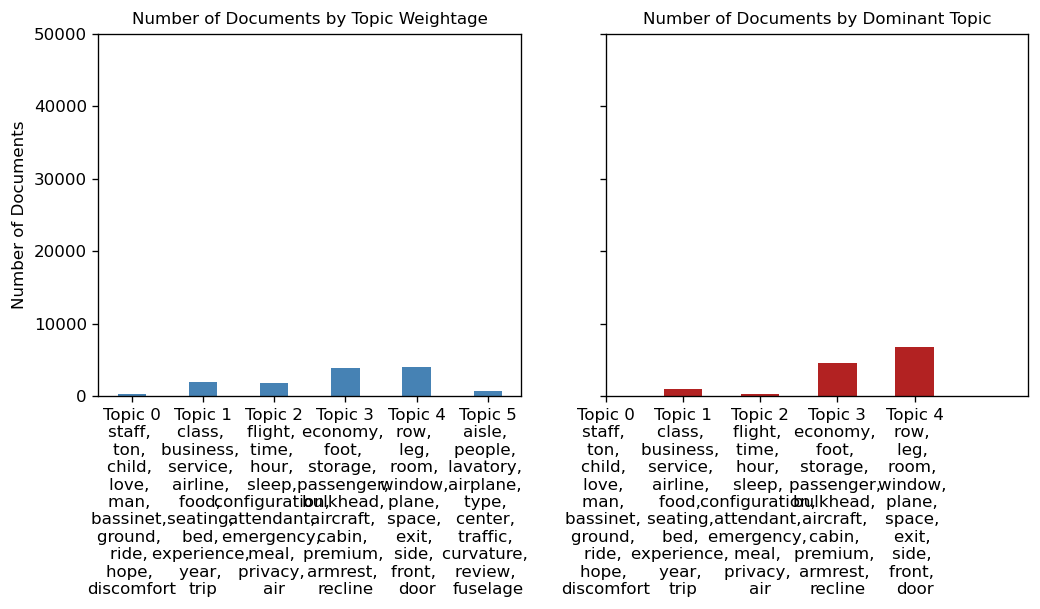

In [233]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# fig, ax2 = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)
# fig, ax1 = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.4, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.set_ylabel('Number of Documents')
ax2.set_ylim(0, 50000)


# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
#ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 50000)

plt.show()

In [234]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7670 samples in 0.021s...
[t-SNE] Computed neighbors for 7670 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7670
[t-SNE] Computed conditional probabilities for sample 2000 / 7670
[t-SNE] Computed conditional probabilities for sample 3000 / 7670
[t-SNE] Computed conditional probabilities for sample 4000 / 7670
[t-SNE] Computed conditional probabilities for sample 5000 / 7670
[t-SNE] Computed conditional probabilities for sample 6000 / 7670
[t-SNE] Computed conditional probabilities for sample 7000 / 7670
[t-SNE] Computed conditional probabilities for sample 7670 / 7670
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.817001
[t-SNE] KL divergence after 1000 iterations: 0.924695


Loading BokehJS ...

In [235]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis
pyLDAvis.save_html(vis, 'topic_model_2.html')

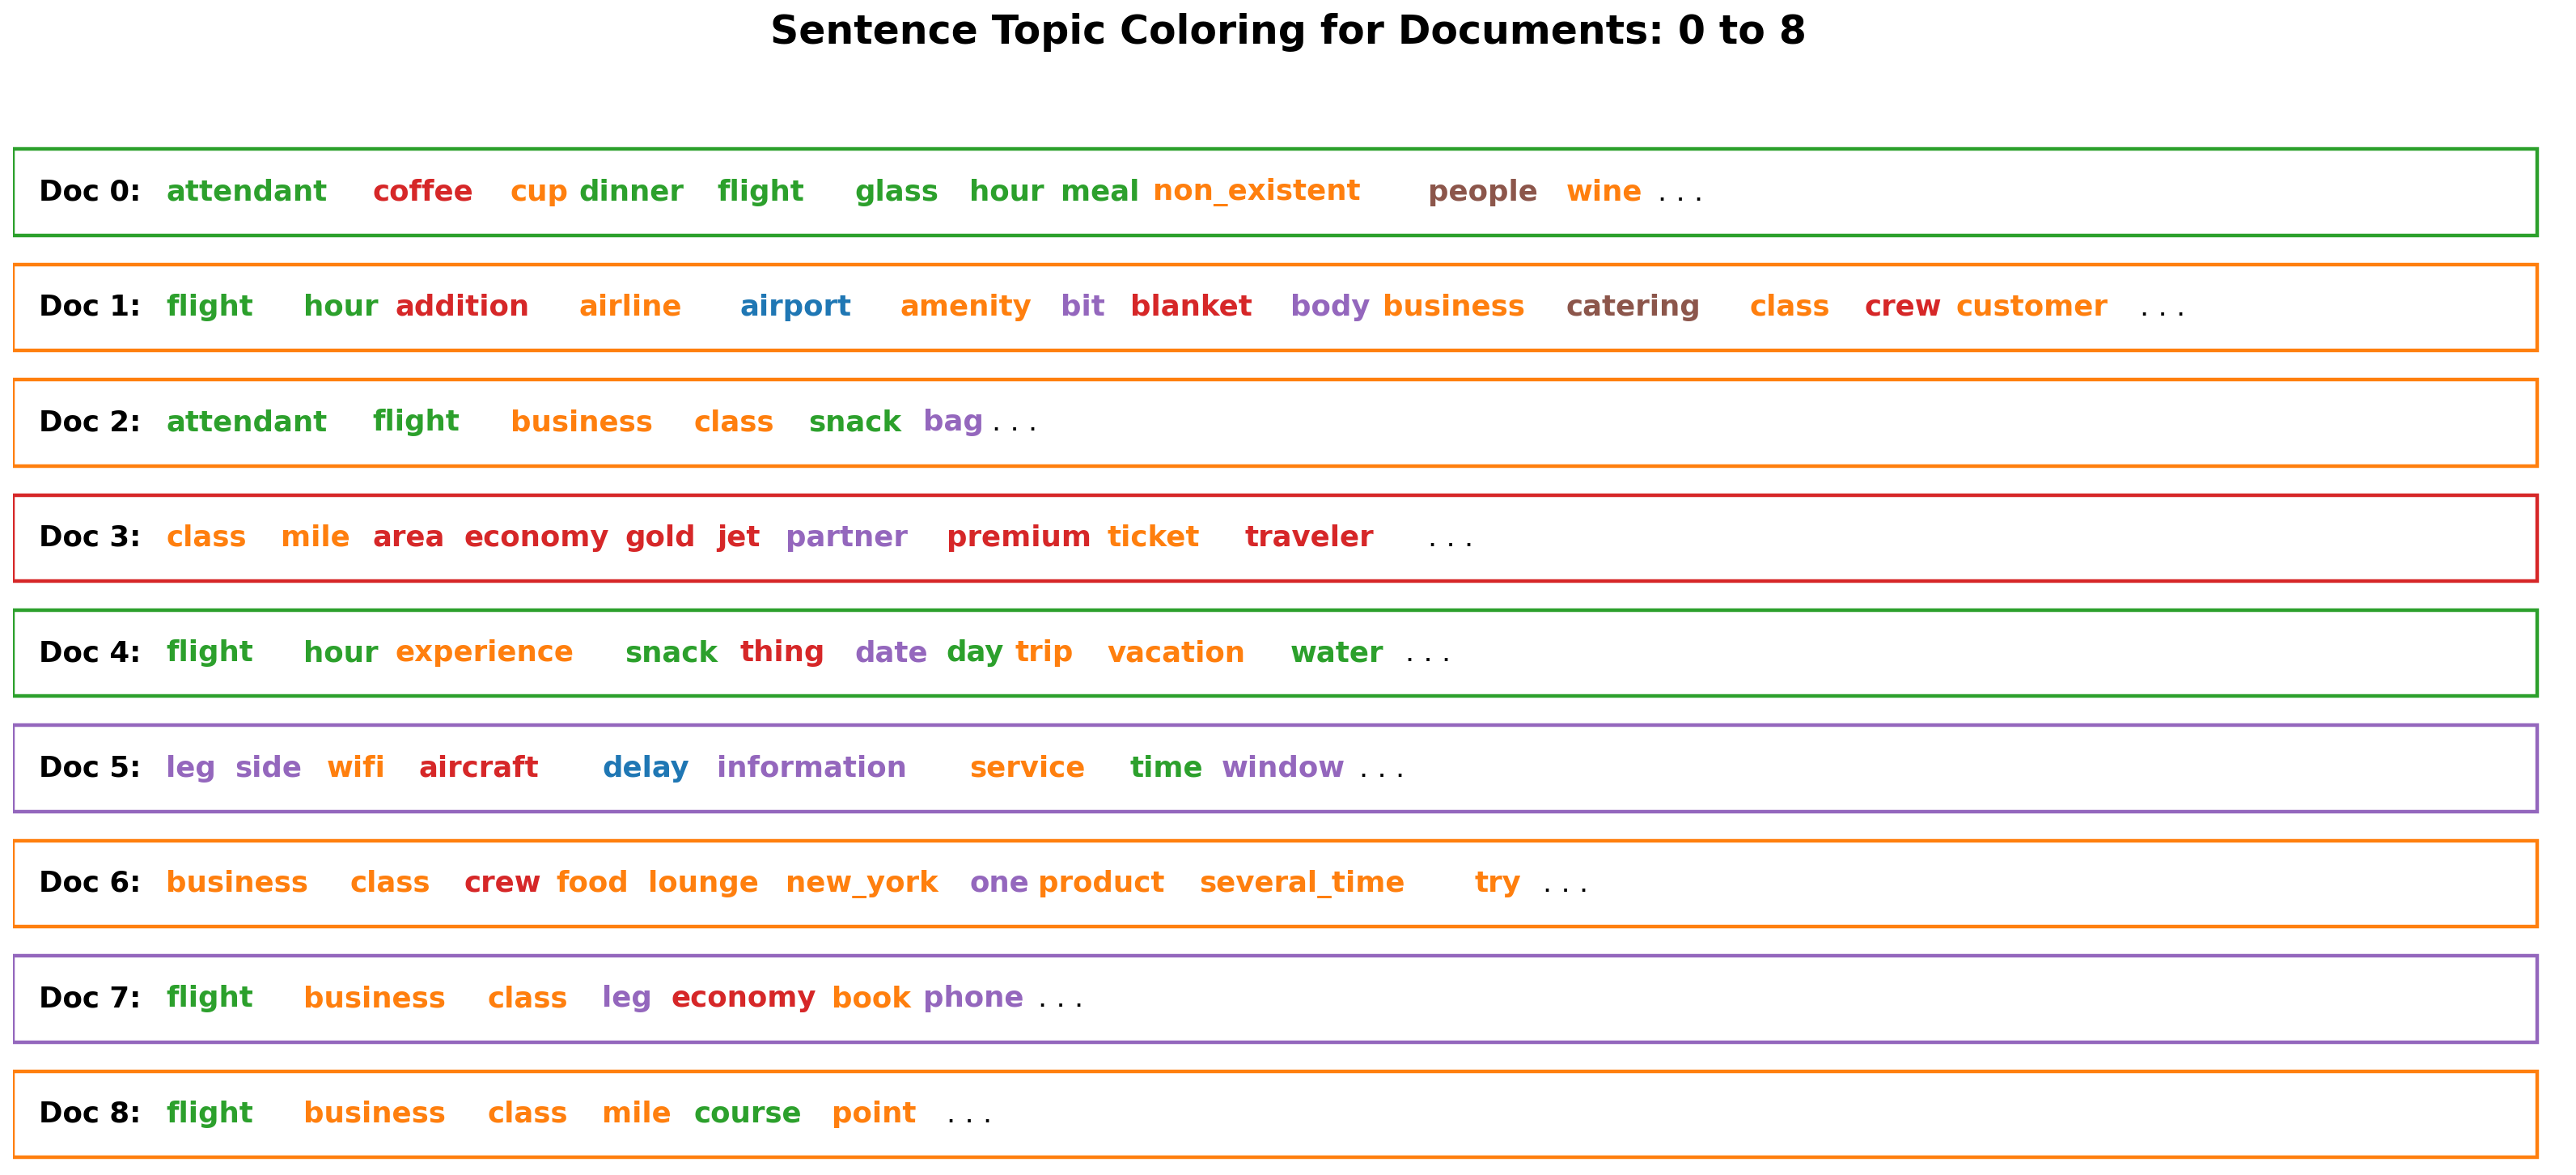

In [236]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  